### Importing necessary packages

In [34]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Checking package versions and GPU availability

In [3]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is available


In [4]:
SEED = 123
BATCH_SIZE = 128

CURRENT_DIR = os.getcwd()
train_dir = os.path.join(CURRENT_DIR, "train_images")
test_dir = os.path.join(CURRENT_DIR, "test_images")

### Setting up EfficientNet V2

In [5]:
model_name = "EfficientNet V2"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
pixels = 300
img_size = (pixels, pixels)

print(f"Selected model: {model_name} -> {model_handle}")
print(f"Input size: {img_size}")

Selected model: EfficientNet V2 -> https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2
Input size: (300, 300)


In [6]:
def build_dataset(subset: str, rnd_seed: int, img_size: tuple[int, int]):
    return tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset=subset,
    label_mode="categorical",
    seed=rnd_seed,
    image_size=img_size,
    batch_size=1,
)

In [7]:
train_dataset = build_dataset("training", SEED, img_size)

class_names = tuple(train_dataset.class_names)
train_size = train_dataset.cardinality().numpy()
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

train_dataset = train_dataset.map(lambda images, labels: 
                                  (preprocessing_model(images), labels))

Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-29 23:26:20.942345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 23:26:20.942663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
val_dataset = build_dataset("validation", SEED, img_size)
val_size = val_dataset.cardinality().numpy()
val_dataset = val_dataset.unbatch().batch(BATCH_SIZE)
val_dataset = val_dataset.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [9]:
print(f"Building model with: {model_handle}")
model = tf.keras.Sequential([
    hub.KerasLayer(model_handle, trainable=False),
])
model.build((None,)+img_size+(3,))
model.summary()

Building model with: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
Total params: 12,930,622
Trainable params: 0
Non-trainable params: 12,930,622
_________________________________________________________________


In [10]:
train_x = []
train_y = []
for tensor in train_dataset:
    features = model.predict(tensor[0], verbose=0)
    classes = tf.keras.backend.get_value(tensor[1])
    for x, y in zip(features, classes):
        train_x += [x]
        train_y += [class_names[np.argmax(y)]]

2022-06-29 23:26:33.220874: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 23:26:34.068955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-29 23:29:07.237352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
val_x = []
val_y = []
for tensor in val_dataset:
    features = model.predict(tensor[0], verbose=0)
    classes = tf.keras.backend.get_value(tensor[1])
    for x, y in zip(features, classes):
        val_x += [x]
        val_y += [class_names[np.argmax(y)]]

In [42]:
svc = SVC(
    kernel="rbf",
    C=30,
    probability=True,
    random_state=SEED,
)

svc.fit(train_x, train_y)

SVC(C=30, probability=True, random_state=123)

Model Accuracy: 96.06%


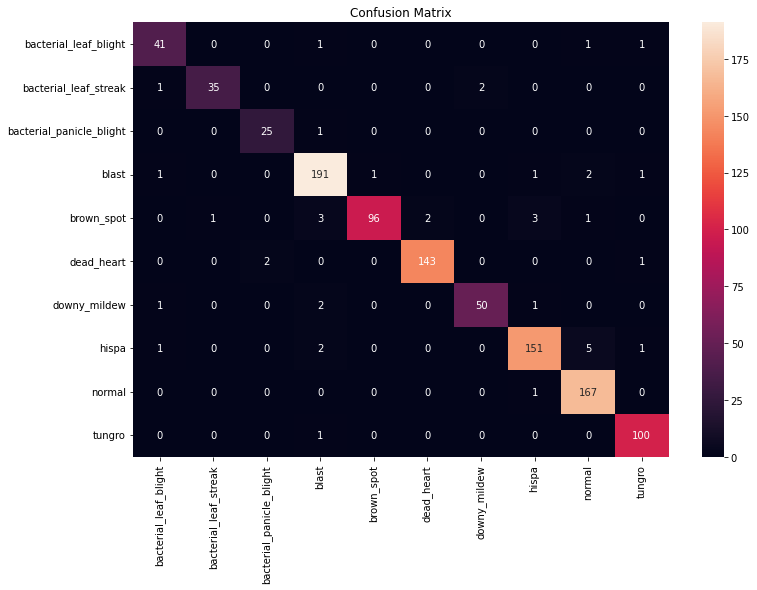

In [44]:
y_pred = svc.predict(val_x)

acc = accuracy_score(val_y, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")

conf_mat = confusion_matrix(val_y, y_pred)

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(df_cm, annot=True, fmt="g")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [14]:
knc = KNeighborsClassifier(
    metric="euclidean",
    n_neighbors=3,
    weights="distance"
)
knc.fit(train_x, train_y)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

Model Accuracy: 94.90%


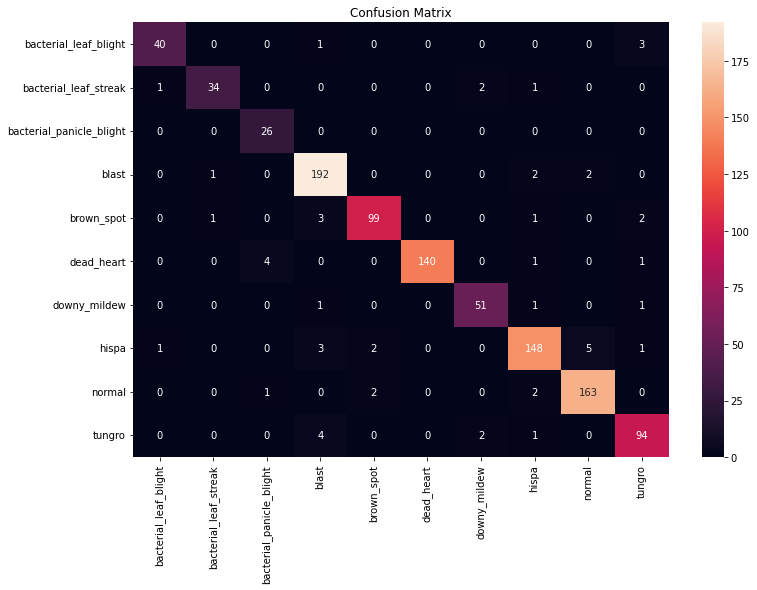

In [15]:
y_pred2 = knc.predict(val_x)

acc = accuracy_score(val_y, y_pred2)
print(f"Model Accuracy: {acc * 100:.2f}%")

conf_mat = confusion_matrix(val_y, y_pred2)

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(df_cm, annot=True, fmt="g")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [52]:
rfc = RandomForestClassifier(
    n_estimators=100,
    max_features=100,
    n_jobs=-1,
    random_state=SEED
)
rfc.fit(train_x, train_y)

RandomForestClassifier(max_features=100, n_jobs=-1, random_state=123)

Model Accuracy: 86.15%


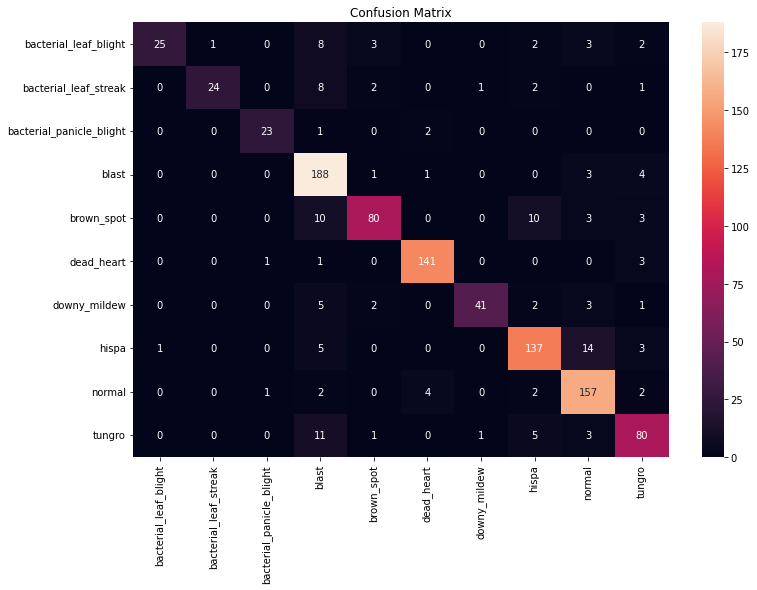

In [53]:
y_pred3 = rfc.predict(val_x)

acc = accuracy_score(val_y, y_pred3)
print(f"Model Accuracy: {acc * 100:.2f}%")

conf_mat = confusion_matrix(val_y, y_pred3)

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(df_cm, annot=True, fmt="g")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [54]:
vc = VotingClassifier(
    estimators=[("SVC", svc), ("RFC", rfc), ("KNN", knc)],
    voting="soft",
    n_jobs=-1
)
vc.fit(train_x, train_y)

VotingClassifier(estimators=[('SVC',
                              SVC(C=30, probability=True, random_state=123)),
                             ('RFC',
                              RandomForestClassifier(max_features=100,
                                                     n_jobs=-1,
                                                     random_state=123)),
                             ('KNN',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3,
                                                   weights='distance'))],
                 n_jobs=-1, voting='soft')

Model Accuracy: 96.25%


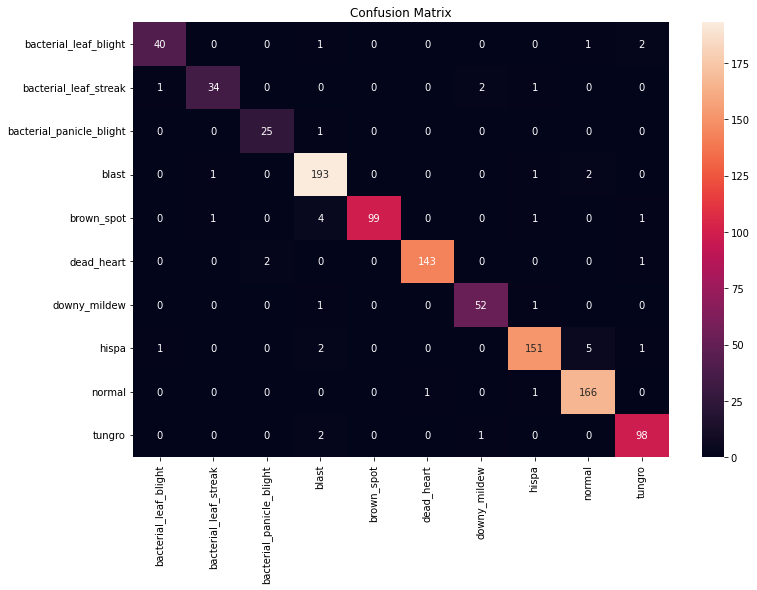

In [55]:
y_pred4 = vc.predict(val_x)

acc = accuracy_score(val_y, y_pred4)
print(f"Model Accuracy: {acc * 100:.2f}%")

conf_mat = confusion_matrix(val_y, y_pred4)

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(df_cm, annot=True, fmt="g")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [56]:
final_x = train_x + val_x
final_y = train_y + val_y

vc.fit(final_x, final_y)

VotingClassifier(estimators=[('SVC',
                              SVC(C=30, probability=True, random_state=123)),
                             ('RFC',
                              RandomForestClassifier(max_features=100,
                                                     n_jobs=-1,
                                                     random_state=123)),
                             ('KNN',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3,
                                                   weights='distance'))],
                 n_jobs=-1, voting='soft')

In [57]:
test_x = []
tensor_batch = []
test_paths = sorted(os.listdir(test_dir))
for i, path in enumerate(test_paths):
    img = tf.io.read_file(os.path.join(test_dir, path))
    tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    tensor = tf.image.resize(tensor, [pixels, pixels])
    tensor = tf.expand_dims(tensor, axis=0)
    features = model.predict(tensor, verbose=0)
    test_x += [features[0]]

In [58]:
final_pred = vc.predict(test_x)

In [59]:
answers = pd.read_csv("sample_submission.csv", sep=",")
answers["label"] = final_pred
answers.to_csv("predictions.csv", sep=",", index=False)